# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [21]:
import glob
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from python_pdb.aligners import align_pandas_structure, align_sequences
from python_pdb.comparisons import rmsd
from python_pdb.entities import Structure
from python_pdb.parsers import parse_pdb, parse_pdb_to_pandas
from python_pdb.formats.residue import THREE_TO_ONE_CODE

from tcr_structure_tools.cdr_numbering import IMGT_CDR1, IMGT_CDR2, IMGT_CDR3, IMGT_CDR, assign_cdr_number

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I-synthetic_refined_aligned'

## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons.

In [3]:
def align_tcrs(tcr_mobile_df, tcr_target_df):            
    mobile_coords = []
    target_coords = []
        
    for chain_type in ('alpha_chain', 'beta_chain'):
        fw_chain_sequences = []
        fw_chain_ca_coords = []
        
        for df in (tcr_mobile_df, tcr_target_df):
            fw_chain = df.query('cdr.isnull() and residue_seq_id < 128 and chain_type == @chain_type')
            
            fw_chain_ca_coords.append(fw_chain.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].values)
            
            fw_chain_seq = fw_chain.drop_duplicates(['residue_seq_id', 'residue_insert_code'])['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
            fw_chain_sequences.append(fw_chain_seq)
        
        fw_chain_seq_alignment, _ = align_sequences(*fw_chain_sequences)
        

        iter_mobile_ca_coords = iter(fw_chain_ca_coords[0])
        iter_target_ca_coords = iter(fw_chain_ca_coords[1])

        for res_id_mobile, res_id_target in fw_chain_seq_alignment:
            next_res_ca_coords_mobile = next(iter_mobile_ca_coords) if res_id_mobile != '-' else None
            next_res_ca_coords_target = next(iter_target_ca_coords) if res_id_target != '-' else None

            if next_res_ca_coords_mobile is not None and next_res_ca_coords_target is not None:
                mobile_coords.append(next_res_ca_coords_mobile)
                target_coords.append(next_res_ca_coords_target)

    mobile_coords = np.array(mobile_coords)
    target_coords = np.array(target_coords)

    return align_pandas_structure(mobile_coords, target_coords, tcr_mobile_df)

In [4]:
CHAIN_ANNOTATION = {
    'D': 'alpha_chain',
    'E': 'beta_chain',
    'C': 'antigen_chain',
    'A': 'mhc_chain',
}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        with open(os.path.join(DATA_DIR, group, path1), 'r') as fh:
            structure1_df = parse_pdb_to_pandas(fh.read())
        
        with open(os.path.join(DATA_DIR, group, path2), 'r') as fh:
            structure2_df = parse_pdb_to_pandas(fh.read())
        
        # Annotate Structure
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATION[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATION[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        structure1_df['backbone'] = structure1_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        structure2_df['backbone'] = structure2_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        
        # Extract and align TCRs
        tcr_1_df = structure1_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        tcr_2_df = structure2_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        tcr_1_aligned_df = align_tcrs(tcr_1_df, tcr_2_df)
        
        # Extract Loops
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            tcr_1_cdr_backbone = tcr_1_aligned_df.query('cdr == @cdr_number and chain_type == @chain_type and backbone')
            tcr_2_cdr_backbone = tcr_2_df.query('cdr == @cdr_number and chain_type == @chain_type and backbone')
            
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
        
            chain_types.append(chain_type)
            cdrs.append(cdr_number)
        
            # Compute Backbone RMSD
            rmsds.append(rmsd(get_coords(tcr_1_cdr_backbone), get_coords(tcr_2_cdr_backbone)))

6vrm_DEPA_holo_ranked_2.pdb 6vrm_DEPA_holo_ranked_0.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vrm_DEPA_holo_ranked_3.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vth_DE_apo_ranked_2.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vth_DE_apo_ranked_0.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vth_DE_apo_ranked_4.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vrm_DEPA_holo_ranked_1.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vth_DE_apo_ranked_3.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vth_DE_apo_ranked_1.pdb
6vrm_DEPA_holo_ranked_2.pdb 6vrm_DEPA_holo_ranked_4.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vrm_DEPA_holo_ranked_3.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vth_DE_apo_ranked_2.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vth_DE_apo_ranked_0.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vth_DE_apo_ranked_4.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vrm_DEPA_holo_ranked_1.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vth_DE_apo_ranked_3.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vth_DE_apo_ranked_1.pdb
6vrm_DEPA_holo_ranked_0.pdb 6vrm_DEPA_holo_ranked_4.pdb
6vrm_DEPA_holo_ranked_3.pdb 6vth_DE_apo_ranked_2.pdb
6vrm_DEPA_holo_ranked_3.p

6eqb_DECA_holo_ranked_2.pdb 4jff_DECA_holo_ranked_2.pdb
6eqb_DECA_holo_ranked_2.pdb 6tmo_DECA_holo_ranked_1.pdb
6eqb_DECA_holo_ranked_2.pdb 4jfe_DECA_holo_ranked_0.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfh_DE_apo_ranked_0.pdb
6eqb_DECA_holo_ranked_4.pdb 6eqb_DECA_holo_ranked_0.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfd_DECA_holo_ranked_3.pdb
6eqb_DECA_holo_ranked_4.pdb 6eqb_DECA_holo_ranked_3.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfh_DE_apo_ranked_1.pdb
6eqb_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_4.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfe_DECA_holo_ranked_2.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfh_DE_apo_ranked_3.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfe_DECA_holo_ranked_3.pdb
6eqb_DECA_holo_ranked_4.pdb 6eqb_DECA_holo_ranked_1.pdb
6eqb_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_3.pdb
6eqb_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_4.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfe_DECA_holo_ranked_4.pdb
6eqb_DECA_holo_ranked_4.pdb 4jfd_DECA_holo_ranked_0.pdb
6eqb_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_2.pdb
6

6tmo_DECA_holo_ranked_4.pdb 4jfd_DECA_holo_ranked_4.pdb
6tmo_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_0.pdb
6tmo_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_0.pdb
6tmo_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_1.pdb
6tmo_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_2.pdb
6tmo_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_1.pdb
6tmo_DECA_holo_ranked_4.pdb 4jfe_DECA_holo_ranked_0.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfh_DE_apo_ranked_3.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfe_DECA_holo_ranked_3.pdb
4jfe_DECA_holo_ranked_2.pdb 6eqb_DECA_holo_ranked_1.pdb
4jfe_DECA_holo_ranked_2.pdb 4jff_DECA_holo_ranked_3.pdb
4jfe_DECA_holo_ranked_2.pdb 4jff_DECA_holo_ranked_4.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfe_DECA_holo_ranked_4.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfd_DECA_holo_ranked_0.pdb
4jfe_DECA_holo_ranked_2.pdb 6tmo_DECA_holo_ranked_2.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfh_DE_apo_ranked_4.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfd_DECA_holo_ranked_2.pdb
4jfe_DECA_holo_ranked_2.pdb 4jfd_DECA_holo_ranked_1.pd

4jfd_DECA_holo_ranked_2.pdb 4jfe_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_1.pdb 4jfd_DECA_holo_ranked_4.pdb
4jfd_DECA_holo_ranked_1.pdb 6tmo_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_1.pdb 4jff_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_1.pdb 4jff_DECA_holo_ranked_1.pdb
4jfd_DECA_holo_ranked_1.pdb 4jff_DECA_holo_ranked_2.pdb
4jfd_DECA_holo_ranked_1.pdb 6tmo_DECA_holo_ranked_1.pdb
4jfd_DECA_holo_ranked_1.pdb 4jfe_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_0.pdb
4jfd_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_1.pdb
4jfd_DECA_holo_ranked_4.pdb 4jff_DECA_holo_ranked_2.pdb
4jfd_DECA_holo_ranked_4.pdb 6tmo_DECA_holo_ranked_1.pdb
4jfd_DECA_holo_ranked_4.pdb 4jfe_DECA_holo_ranked_0.pdb
6tmo_DECA_holo_ranked_0.pdb 4jff_DECA_holo_ranked_0.pdb
6tmo_DECA_holo_ranked_0.pdb 4jff_DECA_holo_ranked_1.pdb
6tmo_DECA_holo_ranked_0.pdb 4jff_DECA_holo_ranked_2.pdb
6tmo_DECA_holo_ranked_0.pdb 6tmo_DECA_holo_ranke

3qeu_DE_apo_ranked_0.pdb 6amu_DECA_holo_ranked_2.pdb
3qeu_DE_apo_ranked_0.pdb 3qeu_DE_apo_ranked_3.pdb
3qeu_DE_apo_ranked_0.pdb 3qeu_DE_apo_ranked_1.pdb
3qeu_DE_apo_ranked_0.pdb 3qeu_DE_apo_ranked_4.pdb
3qeu_DE_apo_ranked_0.pdb 6am5_DECA_holo_ranked_0.pdb
3qeu_DE_apo_ranked_0.pdb 6amu_DECA_holo_ranked_4.pdb
3qeu_DE_apo_ranked_0.pdb 3qdg_DECA_holo_ranked_3.pdb
3qeu_DE_apo_ranked_0.pdb 6am5_DECA_holo_ranked_1.pdb
6amu_DECA_holo_ranked_1.pdb 3qdj_DECA_holo_ranked_0.pdb
6amu_DECA_holo_ranked_1.pdb 3qdg_DECA_holo_ranked_2.pdb
6amu_DECA_holo_ranked_1.pdb 3qdj_DECA_holo_ranked_3.pdb
6amu_DECA_holo_ranked_1.pdb 3qdg_DECA_holo_ranked_0.pdb
6amu_DECA_holo_ranked_1.pdb 6am5_DECA_holo_ranked_2.pdb
6amu_DECA_holo_ranked_1.pdb 6am5_DECA_holo_ranked_3.pdb
6amu_DECA_holo_ranked_1.pdb 3qdj_DECA_holo_ranked_1.pdb
6amu_DECA_holo_ranked_1.pdb 6am5_DECA_holo_ranked_4.pdb
6amu_DECA_holo_ranked_1.pdb 6amu_DECA_holo_ranked_3.pdb
6amu_DECA_holo_ranked_1.pdb 3qdj_DECA_holo_ranked_4.pdb
6amu_DECA_holo_ranked_1.p

3qdj_DECA_holo_ranked_4.pdb 3qdg_DECA_holo_ranked_3.pdb
3qdj_DECA_holo_ranked_4.pdb 6am5_DECA_holo_ranked_1.pdb
6amu_DECA_holo_ranked_2.pdb 3qeu_DE_apo_ranked_3.pdb
6amu_DECA_holo_ranked_2.pdb 3qeu_DE_apo_ranked_1.pdb
6amu_DECA_holo_ranked_2.pdb 3qeu_DE_apo_ranked_4.pdb
6amu_DECA_holo_ranked_2.pdb 6am5_DECA_holo_ranked_0.pdb
6amu_DECA_holo_ranked_2.pdb 6amu_DECA_holo_ranked_4.pdb
6amu_DECA_holo_ranked_2.pdb 3qdg_DECA_holo_ranked_3.pdb
6amu_DECA_holo_ranked_2.pdb 6am5_DECA_holo_ranked_1.pdb
3qeu_DE_apo_ranked_3.pdb 3qeu_DE_apo_ranked_1.pdb
3qeu_DE_apo_ranked_3.pdb 3qeu_DE_apo_ranked_4.pdb
3qeu_DE_apo_ranked_3.pdb 6am5_DECA_holo_ranked_0.pdb
3qeu_DE_apo_ranked_3.pdb 6amu_DECA_holo_ranked_4.pdb
3qeu_DE_apo_ranked_3.pdb 3qdg_DECA_holo_ranked_3.pdb
3qeu_DE_apo_ranked_3.pdb 6am5_DECA_holo_ranked_1.pdb
3qeu_DE_apo_ranked_1.pdb 3qeu_DE_apo_ranked_4.pdb
3qeu_DE_apo_ranked_1.pdb 6am5_DECA_holo_ranked_0.pdb
3qeu_DE_apo_ranked_1.pdb 6amu_DECA_holo_ranked_4.pdb
3qeu_DE_apo_ranked_1.pdb 3qdg_DECA_ho

5nmg_IJHF_holo_ranked_3.pdb 5nmg_IJHF_holo_ranked_2.pdb
5nmg_IJHF_holo_ranked_3.pdb 5nmd_CD_apo_ranked_3.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmd_CD_apo_ranked_4.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmf_DECA_holo_ranked_0.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmg_IJHF_holo_ranked_0.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmf_DECA_holo_ranked_4.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmf_DECA_holo_ranked_2.pdb
5nme_IJHF_holo_ranked_0.pdb 5nme_IJHF_holo_ranked_1.pdb
5nme_IJHF_holo_ranked_0.pdb 5nme_IJHF_holo_ranked_4.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmf_DECA_holo_ranked_1.pdb
5nme_IJHF_holo_ranked_0.pdb 5nme_IJHF_holo_ranked_3.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmg_IJHF_holo_ranked_2.pdb
5nme_IJHF_holo_ranked_0.pdb 5nmd_CD_apo_ranked_3.pdb
5nmd_CD_apo_ranked_4.pdb 5nmf_DECA_holo_ranked_0.pdb
5nmd_CD_apo_ranked_4.pdb 5nmg_IJHF_holo_ranked_0.pdb
5nmd_CD_apo_ranked_4.pdb 5nmf_DECA_holo_ranked_4.pdb
5nmd_CD_apo_ranked_4.pdb 5nmf_DECA_holo_ranked_2.pdb
5nmd_CD_apo_ranked_4.pdb 5nme_IJHF_holo_ranked_1.pdb
5nmd_CD_apo_rank

3vxr_DECA_holo_ranked_3.pdb 3vxs_DECA_holo_ranked_1.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxq_AB_apo_ranked_1.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxr_DECA_holo_ranked_1.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxs_DECA_holo_ranked_2.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxq_AB_apo_ranked_0.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxs_DECA_holo_ranked_0.pdb
3vxr_DECA_holo_ranked_0.pdb 3vxs_DECA_holo_ranked_1.pdb
3vxq_AB_apo_ranked_1.pdb 3vxr_DECA_holo_ranked_1.pdb
3vxq_AB_apo_ranked_1.pdb 3vxs_DECA_holo_ranked_2.pdb
3vxq_AB_apo_ranked_1.pdb 3vxq_AB_apo_ranked_0.pdb
3vxq_AB_apo_ranked_1.pdb 3vxs_DECA_holo_ranked_0.pdb
3vxq_AB_apo_ranked_1.pdb 3vxs_DECA_holo_ranked_1.pdb
3vxr_DECA_holo_ranked_1.pdb 3vxs_DECA_holo_ranked_2.pdb
3vxr_DECA_holo_ranked_1.pdb 3vxq_AB_apo_ranked_0.pdb
3vxr_DECA_holo_ranked_1.pdb 3vxs_DECA_holo_ranked_0.pdb
3vxr_DECA_holo_ranked_1.pdb 3vxs_DECA_holo_ranked_1.pdb
3vxs_DECA_holo_ranked_2.pdb 3vxq_AB_apo_ranked_0.pdb
3vxs_DECA_holo_ranked_2.pdb 3vxs_DECA_holo_ranked_0.pdb
3vxs_DECA_holo_ranked_

3h9s_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_4.pdb
3h9s_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_1.pdb
3h9s_DECA_holo_ranked_1.pdb 3d3v_DECA_holo_ranked_3.pdb
3h9s_DECA_holo_ranked_1.pdb 1qrn_DECA_holo_ranked_1.pdb
3h9s_DECA_holo_ranked_1.pdb 3pwp_DECA_holo_ranked_0.pdb
3h9s_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_0.pdb
3h9s_DECA_holo_ranked_1.pdb 3qfj_DECA_holo_ranked_3.pdb
3h9s_DECA_holo_ranked_1.pdb 1qsf_DECA_holo_ranked_0.pdb
3h9s_DECA_holo_ranked_1.pdb 3d3v_DECA_holo_ranked_2.pdb
3h9s_DECA_holo_ranked_1.pdb 3qh3_AB_apo_ranked_0.pdb
3h9s_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_2.pdb
3h9s_DECA_holo_ranked_1.pdb 3pwp_DECA_holo_ranked_4.pdb
3h9s_DECA_holo_ranked_1.pdb 3d39_DECA_holo_ranked_0.pdb
3h9s_DECA_holo_ranked_1.pdb 1qrn_DECA_holo_ranked_4.pdb
3h9s_DECA_holo_ranked_1.pdb 3pwp_DECA_holo_ranked_2.pdb
3h9s_DECA_holo_ranked_1.pdb 1qsf_DECA_holo_ranked_2.pdb
3h9s_DECA_holo_ranked_1.pdb 1qse_DECA_holo_ranked_1.pdb
3h9s_DECA_holo_ranked_1.pdb 1qrn_DECA_holo_ranked_2

3qfj_DECA_holo_ranked_0.pdb 7amp_AB_apo_ranked_2.pdb
3qfj_DECA_holo_ranked_0.pdb 3d39_DECA_holo_ranked_1.pdb
3qfj_DECA_holo_ranked_0.pdb 1qsf_DECA_holo_ranked_1.pdb
3qfj_DECA_holo_ranked_0.pdb 7amp_AB_apo_ranked_0.pdb
3qfj_DECA_holo_ranked_0.pdb 3qfj_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_0.pdb 1ao7_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_0.pdb 1ao7_DECA_holo_ranked_1.pdb
3qfj_DECA_holo_ranked_0.pdb 3d3v_DECA_holo_ranked_3.pdb
3qfj_DECA_holo_ranked_0.pdb 1qrn_DECA_holo_ranked_1.pdb
3qfj_DECA_holo_ranked_0.pdb 3pwp_DECA_holo_ranked_0.pdb
3qfj_DECA_holo_ranked_0.pdb 1ao7_DECA_holo_ranked_0.pdb
3qfj_DECA_holo_ranked_0.pdb 3qfj_DECA_holo_ranked_3.pdb
3qfj_DECA_holo_ranked_0.pdb 1qsf_DECA_holo_ranked_0.pdb
3qfj_DECA_holo_ranked_0.pdb 3d3v_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_0.pdb 3qh3_AB_apo_ranked_0.pdb
3qfj_DECA_holo_ranked_0.pdb 1ao7_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_0.pdb 3pwp_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_0.pdb 3d39_DECA_holo_ranked_0.pdb
3

3d3v_DECA_holo_ranked_1.pdb 3d39_DECA_holo_ranked_1.pdb
3d3v_DECA_holo_ranked_1.pdb 1qsf_DECA_holo_ranked_1.pdb
3d3v_DECA_holo_ranked_1.pdb 7amp_AB_apo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 3qfj_DECA_holo_ranked_4.pdb
3d3v_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_4.pdb
3d3v_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_1.pdb
3d3v_DECA_holo_ranked_1.pdb 3d3v_DECA_holo_ranked_3.pdb
3d3v_DECA_holo_ranked_1.pdb 1qrn_DECA_holo_ranked_1.pdb
3d3v_DECA_holo_ranked_1.pdb 3pwp_DECA_holo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 3qfj_DECA_holo_ranked_3.pdb
3d3v_DECA_holo_ranked_1.pdb 1qsf_DECA_holo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 3d3v_DECA_holo_ranked_2.pdb
3d3v_DECA_holo_ranked_1.pdb 3qh3_AB_apo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 1ao7_DECA_holo_ranked_2.pdb
3d3v_DECA_holo_ranked_1.pdb 3pwp_DECA_holo_ranked_4.pdb
3d3v_DECA_holo_ranked_1.pdb 3d39_DECA_holo_ranked_0.pdb
3d3v_DECA_holo_ranked_1.pdb 1qrn_DECA_holo_ranked_4.pd

1qse_DECA_holo_ranked_2.pdb 3qh3_AB_apo_ranked_0.pdb
1qse_DECA_holo_ranked_2.pdb 1ao7_DECA_holo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 3pwp_DECA_holo_ranked_4.pdb
1qse_DECA_holo_ranked_2.pdb 3d39_DECA_holo_ranked_0.pdb
1qse_DECA_holo_ranked_2.pdb 1qrn_DECA_holo_ranked_4.pdb
1qse_DECA_holo_ranked_2.pdb 3pwp_DECA_holo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 1qsf_DECA_holo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 1qse_DECA_holo_ranked_1.pdb
1qse_DECA_holo_ranked_2.pdb 1qrn_DECA_holo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 1qse_DECA_holo_ranked_3.pdb
1qse_DECA_holo_ranked_2.pdb 1ao7_DECA_holo_ranked_3.pdb
1qse_DECA_holo_ranked_2.pdb 3qh3_AB_apo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_0.pdb
1qse_DECA_holo_ranked_2.pdb 3d3v_DECA_holo_ranked_4.pdb
1qse_DECA_holo_ranked_2.pdb 3pwp_DECA_holo_ranked_1.pdb
1qse_DECA_holo_ranked_2.pdb 1qsf_DECA_holo_ranked_4.pdb
1qse_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_2.pdb
1qse_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_3.pd

3d39_DECA_holo_ranked_3.pdb 3qfj_DECA_holo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 3qfj_DECA_holo_ranked_2.pdb
3d39_DECA_holo_ranked_3.pdb 1qsf_DECA_holo_ranked_3.pdb
3d39_DECA_holo_ranked_3.pdb 1qse_DECA_holo_ranked_0.pdb
3d39_DECA_holo_ranked_3.pdb 3qh3_AB_apo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 3d39_DECA_holo_ranked_4.pdb
3d39_DECA_holo_ranked_3.pdb 7amp_AB_apo_ranked_2.pdb
3d39_DECA_holo_ranked_3.pdb 3d39_DECA_holo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 1qsf_DECA_holo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 7amp_AB_apo_ranked_0.pdb
3d39_DECA_holo_ranked_3.pdb 3qfj_DECA_holo_ranked_4.pdb
3d39_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_4.pdb
3d39_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 3d3v_DECA_holo_ranked_3.pdb
3d39_DECA_holo_ranked_3.pdb 1qrn_DECA_holo_ranked_1.pdb
3d39_DECA_holo_ranked_3.pdb 3pwp_DECA_holo_ranked_0.pdb
3d39_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_0.pdb
3d39_DECA_holo_ranked_3.pdb 3qfj_DECA_holo_ranked_3.pdb
3

3qfj_DECA_holo_ranked_2.pdb 3d3v_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_2.pdb 3pwp_DECA_holo_ranked_1.pdb
3qfj_DECA_holo_ranked_2.pdb 1qsf_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_3.pdb
3qfj_DECA_holo_ranked_2.pdb 7amp_AB_apo_ranked_3.pdb
3qfj_DECA_holo_ranked_2.pdb 3d39_DECA_holo_ranked_2.pdb
1qsf_DECA_holo_ranked_3.pdb 1qse_DECA_holo_ranked_0.pdb
1qsf_DECA_holo_ranked_3.pdb 3qh3_AB_apo_ranked_1.pdb
1qsf_DECA_holo_ranked_3.pdb 3d39_DECA_holo_ranked_4.pdb
1qsf_DECA_holo_ranked_3.pdb 7amp_AB_apo_ranked_2.pdb
1qsf_DECA_holo_ranked_3.pdb 3d39_DECA_holo_ranked_1.pdb
1qsf_DECA_holo_ranked_3.pdb 1qsf_DECA_holo_ranked_1.pdb
1qsf_DECA_holo_ranked_3.pdb 7amp_AB_apo_ranked_0.pdb
1qsf_DECA_holo_ranked_3.pdb 3qfj_DECA_holo_ranked_4.pdb
1qsf_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_4.pdb
1qsf_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_1.pdb
1qsf_DECA_holo_ranked_3.pdb 3d3v_DECA_holo_ranked_3.pdb
1qsf

7amp_AB_apo_ranked_2.pdb 1qsf_DECA_holo_ranked_1.pdb
7amp_AB_apo_ranked_2.pdb 7amp_AB_apo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 3qfj_DECA_holo_ranked_4.pdb
7amp_AB_apo_ranked_2.pdb 1ao7_DECA_holo_ranked_4.pdb
7amp_AB_apo_ranked_2.pdb 1ao7_DECA_holo_ranked_1.pdb
7amp_AB_apo_ranked_2.pdb 3d3v_DECA_holo_ranked_3.pdb
7amp_AB_apo_ranked_2.pdb 1qrn_DECA_holo_ranked_1.pdb
7amp_AB_apo_ranked_2.pdb 3pwp_DECA_holo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 1ao7_DECA_holo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 3qfj_DECA_holo_ranked_3.pdb
7amp_AB_apo_ranked_2.pdb 1qsf_DECA_holo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 3d3v_DECA_holo_ranked_2.pdb
7amp_AB_apo_ranked_2.pdb 3qh3_AB_apo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 1ao7_DECA_holo_ranked_2.pdb
7amp_AB_apo_ranked_2.pdb 3pwp_DECA_holo_ranked_4.pdb
7amp_AB_apo_ranked_2.pdb 3d39_DECA_holo_ranked_0.pdb
7amp_AB_apo_ranked_2.pdb 1qrn_DECA_holo_ranked_4.pdb
7amp_AB_apo_ranked_2.pdb 3pwp_DECA_holo_ranked_2.pdb
7amp_AB_apo_ranked_2.pdb 1qsf_DECA_holo_ranked_2.pdb

3qfj_DECA_holo_ranked_4.pdb 3h9s_DECA_holo_ranked_3.pdb
3qfj_DECA_holo_ranked_4.pdb 7amp_AB_apo_ranked_3.pdb
3qfj_DECA_holo_ranked_4.pdb 3d39_DECA_holo_ranked_2.pdb
1ao7_DECA_holo_ranked_4.pdb 1ao7_DECA_holo_ranked_1.pdb
1ao7_DECA_holo_ranked_4.pdb 3d3v_DECA_holo_ranked_3.pdb
1ao7_DECA_holo_ranked_4.pdb 1qrn_DECA_holo_ranked_1.pdb
1ao7_DECA_holo_ranked_4.pdb 3pwp_DECA_holo_ranked_0.pdb
1ao7_DECA_holo_ranked_4.pdb 1ao7_DECA_holo_ranked_0.pdb
1ao7_DECA_holo_ranked_4.pdb 3qfj_DECA_holo_ranked_3.pdb
1ao7_DECA_holo_ranked_4.pdb 1qsf_DECA_holo_ranked_0.pdb
1ao7_DECA_holo_ranked_4.pdb 3d3v_DECA_holo_ranked_2.pdb
1ao7_DECA_holo_ranked_4.pdb 3qh3_AB_apo_ranked_0.pdb
1ao7_DECA_holo_ranked_4.pdb 1ao7_DECA_holo_ranked_2.pdb
1ao7_DECA_holo_ranked_4.pdb 3pwp_DECA_holo_ranked_4.pdb
1ao7_DECA_holo_ranked_4.pdb 3d39_DECA_holo_ranked_0.pdb
1ao7_DECA_holo_ranked_4.pdb 1qrn_DECA_holo_ranked_4.pdb
1ao7_DECA_holo_ranked_4.pdb 3pwp_DECA_holo_ranked_2.pdb
1ao7_DECA_holo_ranked_4.pdb 1qsf_DECA_holo_ranked_2.pd

1ao7_DECA_holo_ranked_0.pdb 3h9s_DECA_holo_ranked_0.pdb
1ao7_DECA_holo_ranked_0.pdb 3d3v_DECA_holo_ranked_4.pdb
1ao7_DECA_holo_ranked_0.pdb 3pwp_DECA_holo_ranked_1.pdb
1ao7_DECA_holo_ranked_0.pdb 1qsf_DECA_holo_ranked_4.pdb
1ao7_DECA_holo_ranked_0.pdb 3h9s_DECA_holo_ranked_2.pdb
1ao7_DECA_holo_ranked_0.pdb 3h9s_DECA_holo_ranked_3.pdb
1ao7_DECA_holo_ranked_0.pdb 7amp_AB_apo_ranked_3.pdb
1ao7_DECA_holo_ranked_0.pdb 3d39_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_3.pdb 1qsf_DECA_holo_ranked_0.pdb
3qfj_DECA_holo_ranked_3.pdb 3d3v_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_3.pdb 3qh3_AB_apo_ranked_0.pdb
3qfj_DECA_holo_ranked_3.pdb 1ao7_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_3.pdb 3pwp_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_3.pdb 3d39_DECA_holo_ranked_0.pdb
3qfj_DECA_holo_ranked_3.pdb 1qrn_DECA_holo_ranked_4.pdb
3qfj_DECA_holo_ranked_3.pdb 3pwp_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_3.pdb 1qsf_DECA_holo_ranked_2.pdb
3qfj_DECA_holo_ranked_3.pdb 1qse_DECA_holo_ranked_1.pd

1qrn_DECA_holo_ranked_4.pdb 3d3v_DECA_holo_ranked_4.pdb
1qrn_DECA_holo_ranked_4.pdb 3pwp_DECA_holo_ranked_1.pdb
1qrn_DECA_holo_ranked_4.pdb 1qsf_DECA_holo_ranked_4.pdb
1qrn_DECA_holo_ranked_4.pdb 3h9s_DECA_holo_ranked_2.pdb
1qrn_DECA_holo_ranked_4.pdb 3h9s_DECA_holo_ranked_3.pdb
1qrn_DECA_holo_ranked_4.pdb 7amp_AB_apo_ranked_3.pdb
1qrn_DECA_holo_ranked_4.pdb 3d39_DECA_holo_ranked_2.pdb
3pwp_DECA_holo_ranked_2.pdb 1qsf_DECA_holo_ranked_2.pdb
3pwp_DECA_holo_ranked_2.pdb 1qse_DECA_holo_ranked_1.pdb
3pwp_DECA_holo_ranked_2.pdb 1qrn_DECA_holo_ranked_2.pdb
3pwp_DECA_holo_ranked_2.pdb 1qse_DECA_holo_ranked_3.pdb
3pwp_DECA_holo_ranked_2.pdb 1ao7_DECA_holo_ranked_3.pdb
3pwp_DECA_holo_ranked_2.pdb 3qh3_AB_apo_ranked_2.pdb
3pwp_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_0.pdb
3pwp_DECA_holo_ranked_2.pdb 3d3v_DECA_holo_ranked_4.pdb
3pwp_DECA_holo_ranked_2.pdb 3pwp_DECA_holo_ranked_1.pdb
3pwp_DECA_holo_ranked_2.pdb 1qsf_DECA_holo_ranked_4.pdb
3pwp_DECA_holo_ranked_2.pdb 3h9s_DECA_holo_ranked_2.pd

1mi5_DECA_holo_ranked_4.pdb 1kgc_DE_apo_ranked_3.pdb
1mi5_DECA_holo_ranked_4.pdb 3kpr_DECA_holo_ranked_2.pdb
1mi5_DECA_holo_ranked_4.pdb 1kgc_DE_apo_ranked_1.pdb
1mi5_DECA_holo_ranked_4.pdb 1kgc_DE_apo_ranked_0.pdb
1mi5_DECA_holo_ranked_4.pdb 1mi5_DECA_holo_ranked_1.pdb
1mi5_DECA_holo_ranked_4.pdb 1mi5_DECA_holo_ranked_2.pdb
1mi5_DECA_holo_ranked_4.pdb 3kps_DECA_holo_ranked_2.pdb
1mi5_DECA_holo_ranked_4.pdb 3kpr_DECA_holo_ranked_4.pdb
1mi5_DECA_holo_ranked_4.pdb 3kpr_DECA_holo_ranked_3.pdb
1mi5_DECA_holo_ranked_4.pdb 1kgc_DE_apo_ranked_4.pdb
1mi5_DECA_holo_ranked_4.pdb 3kps_DECA_holo_ranked_0.pdb
1mi5_DECA_holo_ranked_4.pdb 3kps_DECA_holo_ranked_1.pdb
1mi5_DECA_holo_ranked_4.pdb 3kpr_DECA_holo_ranked_0.pdb
1mi5_DECA_holo_ranked_4.pdb 3kps_DECA_holo_ranked_4.pdb
1mi5_DECA_holo_ranked_4.pdb 3kps_DECA_holo_ranked_3.pdb
1mi5_DECA_holo_ranked_4.pdb 1mi5_DECA_holo_ranked_3.pdb
1mi5_DECA_holo_ranked_4.pdb 1kgc_DE_apo_ranked_2.pdb
1kgc_DE_apo_ranked_3.pdb 3kpr_DECA_holo_ranked_2.pdb
1kgc_DE_ap

3kps_DECA_holo_ranked_3.pdb 1kgc_DE_apo_ranked_2.pdb
1mi5_DECA_holo_ranked_3.pdb 1kgc_DE_apo_ranked_2.pdb
7n1c_DE_apo_ranked_2.pdb 7n1c_DE_apo_ranked_1.pdb
7n1c_DE_apo_ranked_2.pdb 7n1e_DECA_holo_ranked_0.pdb
7n1c_DE_apo_ranked_2.pdb 7n1e_DECA_holo_ranked_2.pdb
7n1c_DE_apo_ranked_2.pdb 7n1e_DECA_holo_ranked_1.pdb
7n1c_DE_apo_ranked_2.pdb 7n1c_DE_apo_ranked_0.pdb
7n1c_DE_apo_ranked_2.pdb 7n1e_DECA_holo_ranked_4.pdb
7n1c_DE_apo_ranked_2.pdb 7n1c_DE_apo_ranked_3.pdb
7n1c_DE_apo_ranked_2.pdb 7n1c_DE_apo_ranked_4.pdb
7n1c_DE_apo_ranked_2.pdb 7n1e_DECA_holo_ranked_3.pdb
7n1c_DE_apo_ranked_1.pdb 7n1e_DECA_holo_ranked_0.pdb
7n1c_DE_apo_ranked_1.pdb 7n1e_DECA_holo_ranked_2.pdb
7n1c_DE_apo_ranked_1.pdb 7n1e_DECA_holo_ranked_1.pdb
7n1c_DE_apo_ranked_1.pdb 7n1c_DE_apo_ranked_0.pdb
7n1c_DE_apo_ranked_1.pdb 7n1e_DECA_holo_ranked_4.pdb
7n1c_DE_apo_ranked_1.pdb 7n1c_DE_apo_ranked_3.pdb
7n1c_DE_apo_ranked_1.pdb 7n1c_DE_apo_ranked_4.pdb
7n1c_DE_apo_ranked_1.pdb 7n1e_DECA_holo_ranked_3.pdb
7n1e_DECA_holo

3vxt_CD_apo_ranked_2.pdb 3vxt_CD_apo_ranked_4.pdb
3vxt_CD_apo_ranked_2.pdb 3vxt_CD_apo_ranked_0.pdb
3vxt_CD_apo_ranked_2.pdb 3vxu_DECA_holo_ranked_1.pdb
3vxt_CD_apo_ranked_2.pdb 3vxu_DECA_holo_ranked_3.pdb
3vxt_CD_apo_ranked_2.pdb 3w0w_DECA_holo_ranked_3.pdb
3vxt_CD_apo_ranked_2.pdb 3vxu_DECA_holo_ranked_0.pdb
3vxt_CD_apo_ranked_2.pdb 3w0w_DECA_holo_ranked_4.pdb
3vxt_CD_apo_ranked_2.pdb 3vxt_CD_apo_ranked_3.pdb
3vxt_CD_apo_ranked_2.pdb 3w0w_DECA_holo_ranked_0.pdb
3w0w_DECA_holo_ranked_2.pdb 3w0w_DECA_holo_ranked_1.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxu_DECA_holo_ranked_4.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxt_CD_apo_ranked_1.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxt_CD_apo_ranked_4.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxt_CD_apo_ranked_0.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxu_DECA_holo_ranked_1.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxu_DECA_holo_ranked_3.pdb
3w0w_DECA_holo_ranked_2.pdb 3w0w_DECA_holo_ranked_3.pdb
3w0w_DECA_holo_ranked_2.pdb 3vxu_DECA_holo_ranked_0.pdb
3w0w_DECA_holo_ranked_2.pdb 3w0w_DECA

5hhm_IJHF_holo_ranked_3.pdb 2vlj_DECA_holo_ranked_3.pdb
5hhm_IJHF_holo_ranked_3.pdb 2xna_AB_apo_ranked_1.pdb
5hhm_IJHF_holo_ranked_3.pdb 2vlm_DE_apo_ranked_2.pdb
5hhm_IJHF_holo_ranked_3.pdb 2xna_AB_apo_ranked_2.pdb
5hhm_IJHF_holo_ranked_3.pdb 2vlm_DE_apo_ranked_3.pdb
5hhm_IJHF_holo_ranked_3.pdb 2xna_AB_apo_ranked_0.pdb
5hhm_IJHF_holo_ranked_3.pdb 1oga_DECA_holo_ranked_3.pdb
5hhm_IJHF_holo_ranked_3.pdb 1oga_DECA_holo_ranked_2.pdb
5hhm_IJHF_holo_ranked_3.pdb 5hhm_IJHF_holo_ranked_4.pdb
5hhm_IJHF_holo_ranked_3.pdb 2vlm_DE_apo_ranked_1.pdb
5hhm_IJHF_holo_ranked_3.pdb 2xn9_AB_apo_ranked_3.pdb
5hhm_IJHF_holo_ranked_3.pdb 1oga_DECA_holo_ranked_1.pdb
5hhm_IJHF_holo_ranked_3.pdb 2xn9_AB_apo_ranked_0.pdb
5hhm_IJHF_holo_ranked_2.pdb 2vlm_DE_apo_ranked_0.pdb
5hhm_IJHF_holo_ranked_2.pdb 2vlm_DE_apo_ranked_4.pdb
5hhm_IJHF_holo_ranked_2.pdb 1oga_DECA_holo_ranked_0.pdb
5hhm_IJHF_holo_ranked_2.pdb 2xn9_AB_apo_ranked_4.pdb
5hhm_IJHF_holo_ranked_2.pdb 5hhm_IJHF_holo_ranked_1.pdb
5hhm_IJHF_holo_ranked_2.p

2xn9_AB_apo_ranked_4.pdb 2vlj_DECA_holo_ranked_3.pdb
2xn9_AB_apo_ranked_4.pdb 2xna_AB_apo_ranked_1.pdb
2xn9_AB_apo_ranked_4.pdb 2vlm_DE_apo_ranked_2.pdb
2xn9_AB_apo_ranked_4.pdb 2xna_AB_apo_ranked_2.pdb
2xn9_AB_apo_ranked_4.pdb 2vlm_DE_apo_ranked_3.pdb
2xn9_AB_apo_ranked_4.pdb 2xna_AB_apo_ranked_0.pdb
2xn9_AB_apo_ranked_4.pdb 1oga_DECA_holo_ranked_3.pdb
2xn9_AB_apo_ranked_4.pdb 1oga_DECA_holo_ranked_2.pdb
2xn9_AB_apo_ranked_4.pdb 5hhm_IJHF_holo_ranked_4.pdb
2xn9_AB_apo_ranked_4.pdb 2vlm_DE_apo_ranked_1.pdb
2xn9_AB_apo_ranked_4.pdb 2xn9_AB_apo_ranked_3.pdb
2xn9_AB_apo_ranked_4.pdb 1oga_DECA_holo_ranked_1.pdb
2xn9_AB_apo_ranked_4.pdb 2xn9_AB_apo_ranked_0.pdb
5hhm_IJHF_holo_ranked_1.pdb 2vlk_DECA_holo_ranked_1.pdb
5hhm_IJHF_holo_ranked_1.pdb 2xna_AB_apo_ranked_3.pdb
5hhm_IJHF_holo_ranked_1.pdb 2vlk_DECA_holo_ranked_2.pdb
5hhm_IJHF_holo_ranked_1.pdb 2xn9_AB_apo_ranked_1.pdb
5hhm_IJHF_holo_ranked_1.pdb 1oga_DECA_holo_ranked_4.pdb
5hhm_IJHF_holo_ranked_1.pdb 2vlk_DECA_holo_ranked_0.pdb
5hhm_

1oga_DECA_holo_ranked_4.pdb 2xna_AB_apo_ranked_1.pdb
1oga_DECA_holo_ranked_4.pdb 2vlm_DE_apo_ranked_2.pdb
1oga_DECA_holo_ranked_4.pdb 2xna_AB_apo_ranked_2.pdb
1oga_DECA_holo_ranked_4.pdb 2vlm_DE_apo_ranked_3.pdb
1oga_DECA_holo_ranked_4.pdb 2xna_AB_apo_ranked_0.pdb
1oga_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_3.pdb
1oga_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_2.pdb
1oga_DECA_holo_ranked_4.pdb 5hhm_IJHF_holo_ranked_4.pdb
1oga_DECA_holo_ranked_4.pdb 2vlm_DE_apo_ranked_1.pdb
1oga_DECA_holo_ranked_4.pdb 2xn9_AB_apo_ranked_3.pdb
1oga_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_1.pdb
1oga_DECA_holo_ranked_4.pdb 2xn9_AB_apo_ranked_0.pdb
2vlk_DECA_holo_ranked_0.pdb 2vlk_DECA_holo_ranked_3.pdb
2vlk_DECA_holo_ranked_0.pdb 2vlj_DECA_holo_ranked_4.pdb
2vlk_DECA_holo_ranked_0.pdb 2vlj_DECA_holo_ranked_2.pdb
2vlk_DECA_holo_ranked_0.pdb 2vlj_DECA_holo_ranked_1.pdb
2vlk_DECA_holo_ranked_0.pdb 2xn9_AB_apo_ranked_2.pdb
2vlk_DECA_holo_ranked_0.pdb 5hhm_IJHF_holo_ranked_0.pdb
2vlk_DECA_holo_rank

2vlk_DECA_holo_ranked_4.pdb 2xna_AB_apo_ranked_0.pdb
2vlk_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_3.pdb
2vlk_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_2.pdb
2vlk_DECA_holo_ranked_4.pdb 5hhm_IJHF_holo_ranked_4.pdb
2vlk_DECA_holo_ranked_4.pdb 2vlm_DE_apo_ranked_1.pdb
2vlk_DECA_holo_ranked_4.pdb 2xn9_AB_apo_ranked_3.pdb
2vlk_DECA_holo_ranked_4.pdb 1oga_DECA_holo_ranked_1.pdb
2vlk_DECA_holo_ranked_4.pdb 2xn9_AB_apo_ranked_0.pdb
2vlj_DECA_holo_ranked_0.pdb 2xna_AB_apo_ranked_4.pdb
2vlj_DECA_holo_ranked_0.pdb 2vlj_DECA_holo_ranked_3.pdb
2vlj_DECA_holo_ranked_0.pdb 2xna_AB_apo_ranked_1.pdb
2vlj_DECA_holo_ranked_0.pdb 2vlm_DE_apo_ranked_2.pdb
2vlj_DECA_holo_ranked_0.pdb 2xna_AB_apo_ranked_2.pdb
2vlj_DECA_holo_ranked_0.pdb 2vlm_DE_apo_ranked_3.pdb
2vlj_DECA_holo_ranked_0.pdb 2xna_AB_apo_ranked_0.pdb
2vlj_DECA_holo_ranked_0.pdb 1oga_DECA_holo_ranked_3.pdb
2vlj_DECA_holo_ranked_0.pdb 1oga_DECA_holo_ranked_2.pdb
2vlj_DECA_holo_ranked_0.pdb 5hhm_IJHF_holo_ranked_4.pdb
2vlj_DECA_holo_ranked_

2bnr_DECA_holo_ranked_3.pdb 2bnu_AB_apo_ranked_4.pdb
2bnr_DECA_holo_ranked_3.pdb 6q3s_DECA_holo_ranked_1.pdb
2bnr_DECA_holo_ranked_3.pdb 6q3s_DECA_holo_ranked_2.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnq_DECA_holo_ranked_3.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnr_DECA_holo_ranked_4.pdb
2bnr_DECA_holo_ranked_3.pdb 6q3s_DECA_holo_ranked_0.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnq_DECA_holo_ranked_4.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnu_AB_apo_ranked_1.pdb
2bnr_DECA_holo_ranked_3.pdb 6q3s_DECA_holo_ranked_3.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnr_DECA_holo_ranked_0.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnq_DECA_holo_ranked_2.pdb
2bnr_DECA_holo_ranked_3.pdb 2bnr_DECA_holo_ranked_1.pdb
2bnr_DECA_holo_ranked_2.pdb 2bnu_AB_apo_ranked_2.pdb
2bnr_DECA_holo_ranked_2.pdb 6q3s_DECA_holo_ranked_4.pdb
2bnr_DECA_holo_ranked_2.pdb 2bnq_DECA_holo_ranked_1.pdb
2bnr_DECA_holo_ranked_2.pdb 2bnu_AB_apo_ranked_0.pdb
2bnr_DECA_holo_ranked_2.pdb 2bnu_AB_apo_ranked_4.pdb
2bnr_DECA_holo_ranked_2.pdb 6q3s_DECA_holo_ranked_1.pdb
2bnr_DE

3dx9_AB_apo_ranked_4.pdb 3dxa_DECA_holo_ranked_2.pdb
3dx9_AB_apo_ranked_4.pdb 3dx9_AB_apo_ranked_1.pdb
3dx9_AB_apo_ranked_4.pdb 3dxa_DECA_holo_ranked_0.pdb
3dx9_AB_apo_ranked_4.pdb 3dxa_DECA_holo_ranked_1.pdb
3dx9_AB_apo_ranked_4.pdb 3dx9_AB_apo_ranked_0.pdb
3dx9_AB_apo_ranked_4.pdb 3dxa_DECA_holo_ranked_3.pdb
3dx9_AB_apo_ranked_2.pdb 3dx9_AB_apo_ranked_3.pdb
3dx9_AB_apo_ranked_2.pdb 3dxa_DECA_holo_ranked_4.pdb
3dx9_AB_apo_ranked_2.pdb 3dxa_DECA_holo_ranked_2.pdb
3dx9_AB_apo_ranked_2.pdb 3dx9_AB_apo_ranked_1.pdb
3dx9_AB_apo_ranked_2.pdb 3dxa_DECA_holo_ranked_0.pdb
3dx9_AB_apo_ranked_2.pdb 3dxa_DECA_holo_ranked_1.pdb
3dx9_AB_apo_ranked_2.pdb 3dx9_AB_apo_ranked_0.pdb
3dx9_AB_apo_ranked_2.pdb 3dxa_DECA_holo_ranked_3.pdb
3dx9_AB_apo_ranked_3.pdb 3dxa_DECA_holo_ranked_4.pdb
3dx9_AB_apo_ranked_3.pdb 3dxa_DECA_holo_ranked_2.pdb
3dx9_AB_apo_ranked_3.pdb 3dx9_AB_apo_ranked_1.pdb
3dx9_AB_apo_ranked_3.pdb 3dxa_DECA_holo_ranked_0.pdb
3dx9_AB_apo_ranked_3.pdb 3dxa_DECA_holo_ranked_1.pdb
3dx9_AB_apo

In [14]:
results = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results

,group,struct1,struct2,chain_type,cdr,rmsd
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,1,0.481875
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,2,2.588575
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,3,0.520469
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,1,0.388672
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,2,0.290176
...,...,...,...,...,...,...
23815,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,2,0.296376
23816,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,3,0.707593
23817,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,1,0.609733
23818,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,2,0.343650


In [15]:
results['struct1_form'] = results['struct1'].map(lambda path: path.split('.')[0].split('_')[2])
results['struct2_form'] = results['struct2'].map(lambda path: path.split('.')[0].split('_')[2])
results['combined_structures'] = results.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)
results = results.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])
results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,1,0.481875,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,2,2.588575,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,3,0.520469,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,1,0.388672,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,2,0.290176,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...
...,...,...,...,...,...,...,...,...,...
23815,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,2,0.296376,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...
23816,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,3,0.707593,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...
23817,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,1,0.609733,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...
23818,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,2,0.343650,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...


In [16]:
results['struct_1_model_rank'] = results['struct1'].map(lambda path: int(path.split('_')[-1].split('.')[0]))
results['struct_2_model_rank'] = results['struct2'].map(lambda path: int(path.split('_')[-1].split('.')[0]))

results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,struct_1_model_rank,struct_2_model_rank
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,1,0.481875,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...,2,0
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,2,2.588575,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...,2,0
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,alpha_chain,3,0.520469,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...,2,0
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,1,0.388672,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...,2,0
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vrm_DEPA_holo_ranked_0.pdb,beta_chain,2,0.290176,holo,holo,6vrm_DEPA_holo_ranked_0.pdb-6vrm_DEPA_holo_ran...,2,0
...,...,...,...,...,...,...,...,...,...,...,...
23815,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,2,0.296376,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...,0,3
23816,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,alpha_chain,3,0.707593,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...,0,3
23817,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,1,0.609733,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...,0,3
23818,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,beta_chain,2,0.343650,apo,holo,3dx9_AB_apo_ranked_0.pdb-3dxa_DECA_holo_ranked...,0,3


In [24]:
results_norm = results.groupby(['group',
                 'chain_type',
                 'cdr',
                 'struct1_form', 'struct2_form',
                 'struct_1_model_rank', 'struct_2_model_rank'])['rmsd'].mean().reset_index()

In [25]:
movement_order = pd.CategoricalDtype(categories=['little movement', 'some movement', 'movement', 'large movement', 'significant movement'], ordered=True)

def categorize_movement(rmsd: float) -> str:
    if rmsd < 0.5:
        return 'little movement'
    
    if 0.5 <= rmsd < 1.0:
        return 'some movement'
    
    if 1.0 <= rmsd < 2.0:
        return 'movement'
    
    if 2.0 <= rmsd < 4.0:
        return 'large movement'
    
    if 4.0 <= rmsd:
        return 'significant movement'

results_norm['movement'] = results_norm['rmsd'].map(categorize_movement).astype(movement_order)
results_norm

,group,chain_type,cdr,struct1_form,struct2_form,struct_1_model_rank,struct_2_model_rank,rmsd,movement
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,apo,0,1,0.258101,little movement
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,apo,0,3,0.533428,some movement
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,apo,0,4,0.423521,little movement
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,apo,2,0,0.349840,little movement
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,apo,2,1,0.205452,little movement
...,...,...,...,...,...,...,...,...,...
6193,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,holo,4,0,0.264133,little movement
6194,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,holo,4,1,0.207803,little movement
6195,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,holo,4,2,0.234404,little movement
6196,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,holo,4,3,0.236816,little movement


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

In [26]:
apo_holo = results_norm.query('(struct1_form != struct2_form) and (struct_1_model_rank == struct_2_model_rank)').copy()
apo_holo['model_rank'] = apo_holo['struct_1_model_rank'] 
apo_holo

,group,chain_type,cdr,struct1_form,struct2_form,struct_1_model_rank,struct_2_model_rank,rmsd,movement,model_rank
17,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,apo,holo,4,4,1.044212,movement,4
18,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,holo,apo,0,0,0.508221,some movement,0
23,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,holo,apo,1,1,0.962308,some movement,1
27,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,holo,apo,2,2,0.771641,some movement,2
33,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha_chain,1,holo,apo,3,3,0.569017,some movement,3
...,...,...,...,...,...,...,...,...,...,...
6153,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,apo,holo,4,4,0.144704,little movement,4
6154,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,apo,0,0,0.335521,little movement,0
6160,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,apo,1,1,0.355501,little movement,1
6164,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,beta_chain,3,holo,apo,2,2,0.116308,little movement,2


count      mean       std       min       25%       50%  \
cdr chain_type                                                             
1   alpha_chain   22.0  0.413752  0.313557  0.118830  0.174413  0.333875   
    beta_chain    22.0  0.305752  0.235806  0.081176  0.174568  0.231118   
2   alpha_chain   22.0  0.432328  0.354917  0.155527  0.215941  0.270476   
    beta_chain    22.0  0.399874  0.488308  0.104778  0.194565  0.283333   
3   alpha_chain   22.0  0.836686  0.619864  0.190624  0.352804  0.709298   
    beta_chain    22.0  0.808871  0.601380  0.204849  0.339830  0.565968   

                      75%       max  
cdr chain_type                       
1   alpha_chain  0.507940  1.228071  
    beta_chain   0.338603  1.045247  
2   alpha_chain  0.493907  1.508756  
    beta_chain   0.335774  2.483826  
3   alpha_chain  1.091008  2.560057  
    beta_chain   1.239458  2.169404

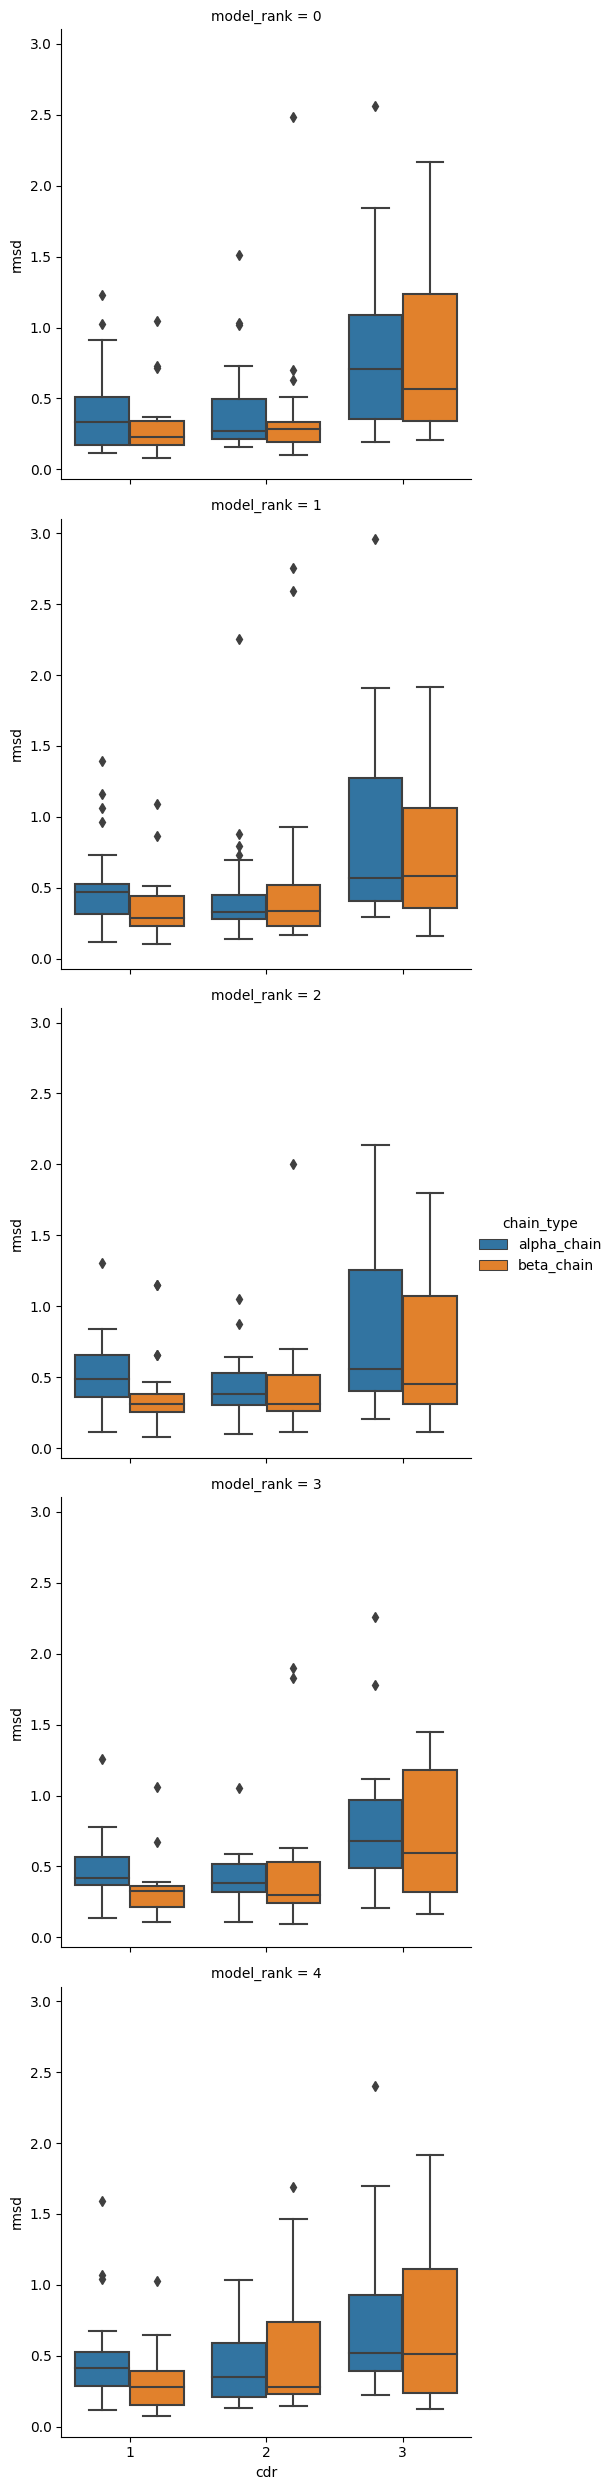

In [27]:
sns.catplot(data=apo_holo, y='rmsd', x='cdr', hue='chain_type', row='model_rank', kind='box')

apo_holo.query('struct_1_model_rank == 0').groupby(['cdr', 'chain_type'])['rmsd'].describe()

The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

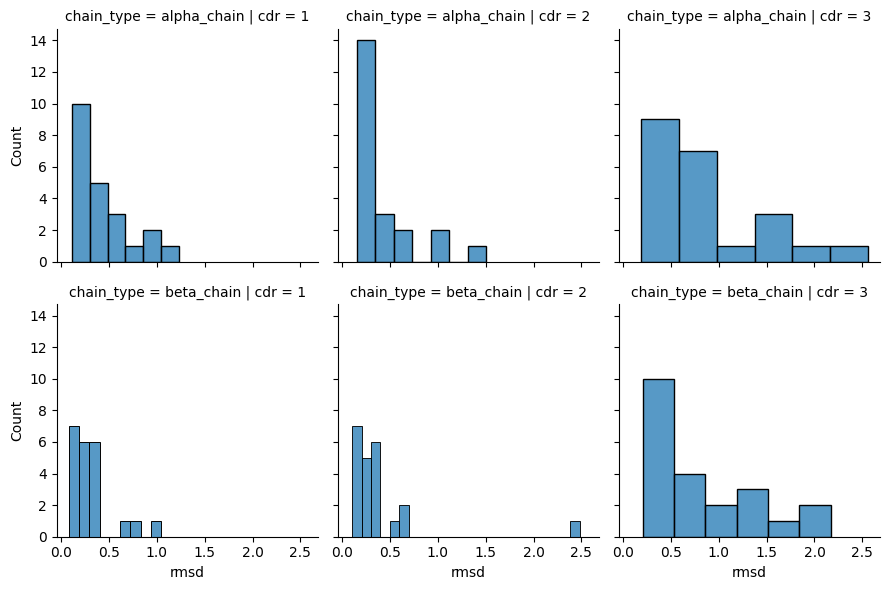

In [28]:
g = sns.FacetGrid(apo_holo.query('struct_1_model_rank == 0'), row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

The RMSD distributions are somewhat left skewed and don't look particularily normal.

<Axes: ylabel='count'>

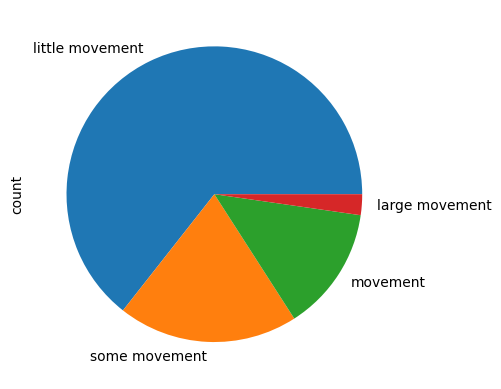

In [29]:
apo_holo.query('struct_1_model_rank == 0')['movement'].value_counts().plot.pie()

## Comparison of *apo*-*apo* and *holo*-*holo* to *apo*-*holo* (or vice versa) structures

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *apo*-*apo* and *holo*-*holo* differences as controls.

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


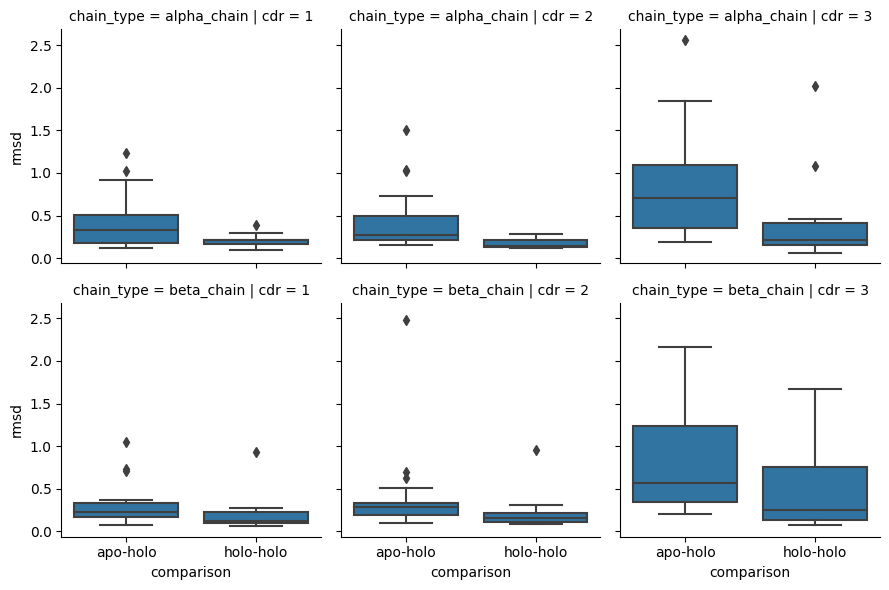

In [30]:
results_norm['comparison'] = results_norm['struct1_form'] + '-' + results_norm['struct2_form']
results_norm['comparison'] = results_norm['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

g = sns.FacetGrid(results_norm.query("(struct_1_model_rank == struct_2_model_rank == 0) and comparison != 'apo-apo'").sort_values('comparison'), col='cdr', row='chain_type')
g.map(sns.boxplot, 'comparison', 'rmsd')
# plt.savefig('figures/movement-comparison-tcrmodel2_updated.svg')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


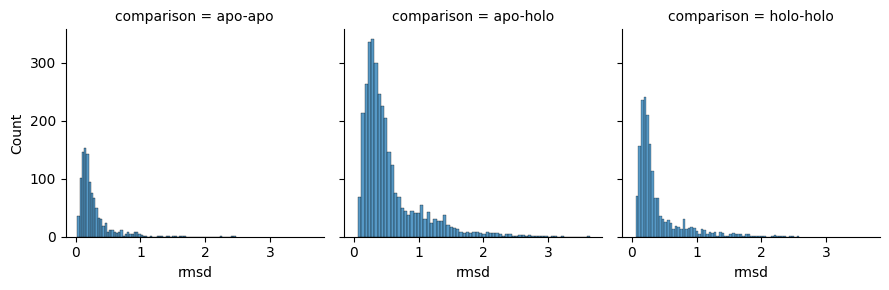

In [31]:
g = sns.FacetGrid(results_norm.sort_values('comparison'), col='comparison')
g.map(sns.histplot, 'rmsd')

In [34]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['rmsd'].to_numpy()) for group, df in results_norm.query("(struct_1_model_rank == 0)  and comparison != 'apo-apo'").groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=204.82982101805646, pvalue=7.393700703798076e-38)


In [35]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]
    
    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

0.008333333333333333


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-holo,alpha_chain,1,holo-holo,alpha_chain,1,3.160522,0.001575,True
1,apo-holo,alpha_chain,2,holo-holo,alpha_chain,2,4.077038,0.000046,True
2,apo-holo,alpha_chain,3,holo-holo,alpha_chain,3,2.956852,0.003108,True
3,apo-holo,beta_chain,1,holo-holo,beta_chain,1,2.269466,0.023240,False
4,apo-holo,beta_chain,2,holo-holo,beta_chain,2,3.495123,0.000474,True
5,apo-holo,beta_chain,3,holo-holo,beta_chain,3,1.858489,0.063100,False


In [36]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)

statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)
    
    statistics.append(stat)
    p_vals.append(p_val)

post_hoc = pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})
post_hoc.query("significant == True")

,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
1,apo-holo,alpha_chain,1,apo-holo,alpha_chain,3,-5.813200,6.128993e-09,True
2,apo-holo,alpha_chain,1,apo-holo,beta_chain,1,4.077984,4.542791e-05,True
4,apo-holo,alpha_chain,1,apo-holo,beta_chain,3,-4.125680,3.696416e-05,True
6,apo-holo,alpha_chain,1,holo-holo,alpha_chain,2,3.967929,7.250004e-05,True
8,apo-holo,alpha_chain,1,holo-holo,beta_chain,1,4.673500,2.961100e-06,True
9,apo-holo,alpha_chain,1,holo-holo,beta_chain,2,3.927922,8.568298e-05,True
11,apo-holo,alpha_chain,2,apo-holo,alpha_chain,3,-6.103916,1.035005e-09,True
14,apo-holo,alpha_chain,2,apo-holo,beta_chain,3,-4.920608,8.627567e-07,True
16,apo-holo,alpha_chain,2,holo-holo,alpha_chain,2,4.077038,4.561312e-05,True
18,apo-holo,alpha_chain,2,holo-holo,beta_chain,1,4.684411,2.807665e-06,True


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

# ⚠️ THE FOLLOWING SECTION IS NO LONGER NEEDED

The analysis above has been done in a more normalized way now.

## ... suspect that this is a popularity contest

That being said, based on the method in the first part of this analysis, more popular TCRs dominate the dataset and potentially cause some bias in results. Taking a look at the data, there are a few TCRs that have much higher abundance then others.

In [17]:
apo_holo['group'].value_counts()

group
SLNCTYSDRGSQSFFWYRQY-SPELIMSIYSNGDKEDGRFTAQL-ATYLCAVTTDSWGKLQFGAGTQ-TLQCAQDMNHEYMSWYRQD-GLRLIHYSVGAGITDQGEVPNGYNVSR-SVYFCASRPGLAGGRPEQYFGPGTR     540
TVYCNSSSVFSSLQWYRQE-GPVLLVTVVTGGEVKKLKRLTFQF-GLYLCAGAGSQGNLIFGKGTK-TLSCEQNLNHDAMYWYRQD-GLRLIYYSQIVNDFQKGDIAEGYSVSR-AFYLCASSSRSSYEQYFGPGTR         360
SLNCTYSFLGSQSFFWYRQY-SPELIMFTYREGDKEDGRFTAQL-ATYLCAVNDGGRLTFGDGTT-SLECTVEGTSNPNLYWYRQA-GPQLLFYWGPFGQISSEVPQNLSASR-GFYLCAWSETGLGMGGWQFGEGSR        150
SLNCTYSDRGSQSFFWYRQY-SPELIMFIYSNGDKEDGRFTAQL-ATYLCAVNFGGGKLIFGQGTE-TLRCTQDMRHNAMYWYRQD-GLRLIHYSNTAGTTGKGEVPDGYSVSR-SVYFCASSLSFGTEAFFGQGTR         120
SLNCTYSDRGSQSFFWYRQY-SPELIMFIYSNGDKEDGRFTAQL-ATYLCAVRTNSGYALNFGKGTS-TLRCSPKQGHDTVSWYQQA-GPQFIFQYYEEEERQRGNFPDRFSGHQ-ALYLCASSDTVSYEQYFGPGTR         90
HLPCNHSTISGTDYIHWYRQL-GPEYVIHGLTSNVNNRMASLAI-AVYYCILPLAGGTSYGKLTFGQGTI-ALRCDPISGHVSLFWYQQA-GPEFLTYFQNEAQLDKSGLPSDRFFAER-AVYLCASSLGQAYEQYFGPGTR     90
VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-ATYLCAVRPTSGGSYIPTFGRGTS-TLQCAQDMNHEYMSWYRQD-GLR

# Re-doing the calculations using average *apo* and *holo* comformation

To remove the effects of this bias, the following section used a different approach, taking the average position of the *apo* forms and comparing it to the average position of the *holo* forms. In this way, each TCR will have one corresponding RMSD measurement.

In [19]:
groups = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(DATA_DIR):
    apo_files = glob.glob(os.path.join(DATA_DIR, group, '*apo*.pdb'))
    holo_files = glob.glob(os.path.join(DATA_DIR, group, '*holo*.pdb'))
    
    if len(apo_files) == 0 or len(holo_files) == 0:
        print(group)
        print()
        continue
    
    num_apo_files = len(apo_files)
    num_holo_files = len(holo_files)
    
    apo_avg_cdr_1_alpha_coords = None
    apo_avg_cdr_2_alpha_coords = None
    apo_avg_cdr_3_alpha_coords = None
    apo_avg_cdr_1_beta_coords = None
    apo_avg_cdr_2_beta_coords = None
    apo_avg_cdr_3_beta_coords = None
    
    for path in apo_files:
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATION[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        apo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if apo_avg_cdr_1_alpha_coords is None else apo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        apo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if apo_avg_cdr_2_alpha_coords is None else apo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        apo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if apo_avg_cdr_3_alpha_coords is None else apo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        apo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if apo_avg_cdr_1_beta_coords is None else apo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        apo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if apo_avg_cdr_2_beta_coords is None else apo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        apo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if apo_avg_cdr_3_beta_coords is None else apo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    apo_avg_cdr_1_alpha_coords /= num_apo_files
    apo_avg_cdr_2_alpha_coords /= num_apo_files
    apo_avg_cdr_3_alpha_coords /= num_apo_files
    apo_avg_cdr_1_beta_coords /= num_apo_files
    apo_avg_cdr_2_beta_coords /= num_apo_files
    apo_avg_cdr_3_beta_coords /= num_apo_files

    holo_avg_cdr_1_alpha_coords = None
    holo_avg_cdr_2_alpha_coords = None
    holo_avg_cdr_3_alpha_coords = None
    holo_avg_cdr_1_beta_coords = None
    holo_avg_cdr_2_beta_coords = None
    holo_avg_cdr_3_beta_coords = None
    
    for path in holo_files:
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATION[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        holo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if holo_avg_cdr_1_alpha_coords is None else holo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        holo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if holo_avg_cdr_2_alpha_coords is None else holo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        holo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if holo_avg_cdr_3_alpha_coords is None else holo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        holo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if holo_avg_cdr_1_beta_coords is None else holo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        holo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if holo_avg_cdr_2_beta_coords is None else holo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        holo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if holo_avg_cdr_3_beta_coords is None else holo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    holo_avg_cdr_1_alpha_coords /= num_holo_files
    holo_avg_cdr_2_alpha_coords /= num_holo_files
    holo_avg_cdr_3_alpha_coords /= num_holo_files
    holo_avg_cdr_1_beta_coords /= num_holo_files
    holo_avg_cdr_2_beta_coords /= num_holo_files
    holo_avg_cdr_3_beta_coords /= num_holo_files
    
    for _ in range(6):
        groups.append(group)

    for _ in range(3):
        chain_types.append('alpha')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_alpha_coords, holo_avg_cdr_1_alpha_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_alpha_coords, holo_avg_cdr_2_alpha_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_alpha_coords, holo_avg_cdr_3_alpha_coords))

    for _ in range(3):
        chain_types.append('beta')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_beta_coords, holo_avg_cdr_1_beta_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_beta_coords, holo_avg_cdr_2_beta_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_beta_coords, holo_avg_cdr_3_beta_coords))

QLRCKYSYSATPYLFWYVQY-GLQLLLKYYSGDPVVQGVNGFEAEF-AVYFCAVSGFASALTFGSGTK-TLSCNQTNNHNNMYWYRQD-GLRLIHYSYGAGSTEKGDIPDGYKASR-SVYFCASGGGGTLYFGAGTR

SLNCTYSNSAFQYFMWYRQY-GPELLMYTYSSGNKEDGRFTAQV-ATYLCAMRGDSSYKLIFGSGTR-TLRCKPISGHDYLFWYRQT-GLELLIYFNNNVPIDDSGMPEDRFSAKM-AVYFCASSLWEKLAKNIQYFGAGTR

AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-ATYLCVVRAGKLIFGQGTE-TLLCAQDMNHEYMYWYRQD-GLRLIHYSVGEGTTAKGEVPDGYNVSR-SVYFCASGQGNFDIQYFGAGTR

ILNCSYEDSTFNYFPWYQQF-GPALLISIRSVSDKKEDGRFTIFF-ATYFCAARYQGGRALIFGTGTT-NLRCILKNSQYPWMSWYQQD-QLQWLFTLRSPGDKEVKSLPGADYLATR-RTLYCTCSAAPDWGASAETLYFGSGTR

NITCSHNNIATNDYITWYQQF-GPRFIIQGYKTKVTNEVASLFI-AVYYCLVGEILDNFNKFYFGSGTK-FLECVQDMDHENMFWYRQD-GLRLIYFSYDVKMKEKGDIPEGYSVSR-SMYLCASSQRQEGDTQYFGPGTR



In [20]:
results_avg = pd.DataFrame(zip(groups, chain_types, cdrs, rmsds), columns=['group', 'chain_type', 'cdr', 'rmsd'])
results_avg

,group,chain_type,cdr,rmsd
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha,CDR1,12.783834
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha,CDR2,16.738973
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,alpha,CDR3,14.320287
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,beta,CDR1,14.387792
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,beta,CDR2,12.138615
...,...,...,...,...
91,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,alpha,CDR2,26.452877
92,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,alpha,CDR3,14.791269
93,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,beta,CDR1,10.485583
94,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,beta,CDR2,3.821422


<Axes: ylabel='count'>

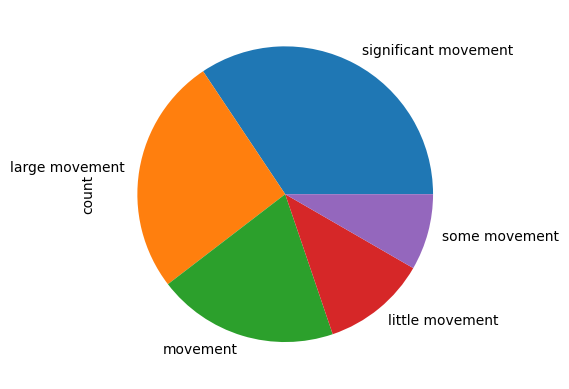

In [21]:
results_avg['movement'] = results_avg['rmsd'].map(categorize_movement)

results_avg['movement'].value_counts().plot.pie()

count       mean        std       min       25%       50%   
cdr  chain_type                                                              
CDR1 alpha        16.0   8.380043  10.338951  0.271097  1.345922  2.440638  \
     beta         16.0   9.554796  14.109701  0.175542  1.421941  2.539708   
CDR2 alpha        16.0  10.559425  13.284432  0.314255  1.837461  3.089944   
     beta         16.0   9.089782  14.725942  0.137132  1.124565  2.470731   
CDR3 alpha        16.0   8.187960  11.459616  0.402927  1.230850  2.354492   
     beta         16.0   8.495546  12.300607  0.350568  0.947522  2.442605   

                       75%        max  
cdr  chain_type                        
CDR1 alpha       14.670315  27.902002  
     beta        11.461136  46.084571  
CDR2 alpha       18.835387  42.069916  
     beta         6.030385  49.232874  
CDR3 alpha       13.233058  35.020709  
     beta        12.985734  39.178938

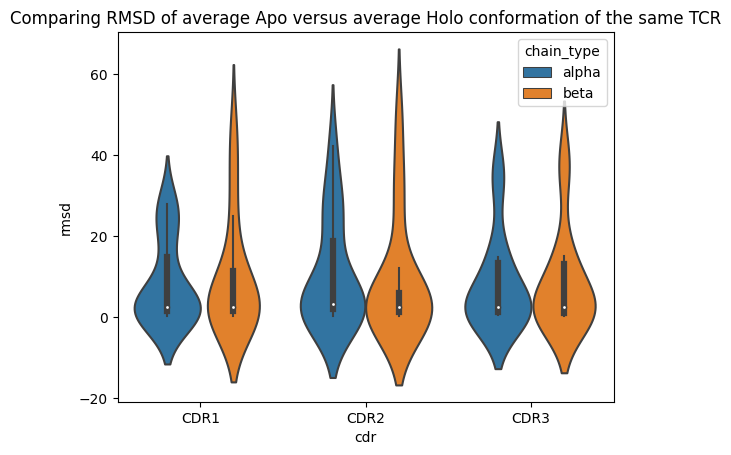

In [22]:
sns.violinplot(data=results_avg, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of average Apo versus average Holo conformation of the same TCR')

results_avg.groupby(['cdr', 'chain_type'])['rmsd'].describe()

The plots seem to show the same trend as before which is reassuring.

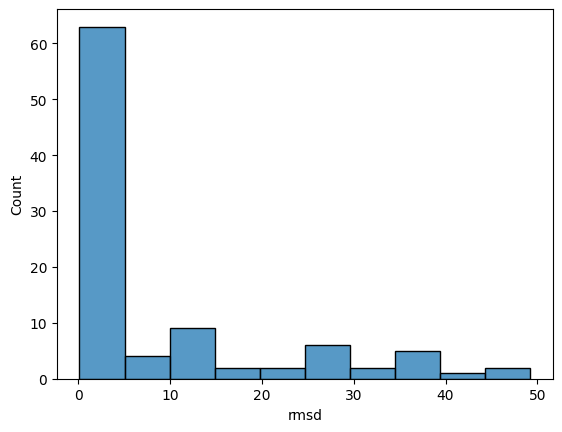

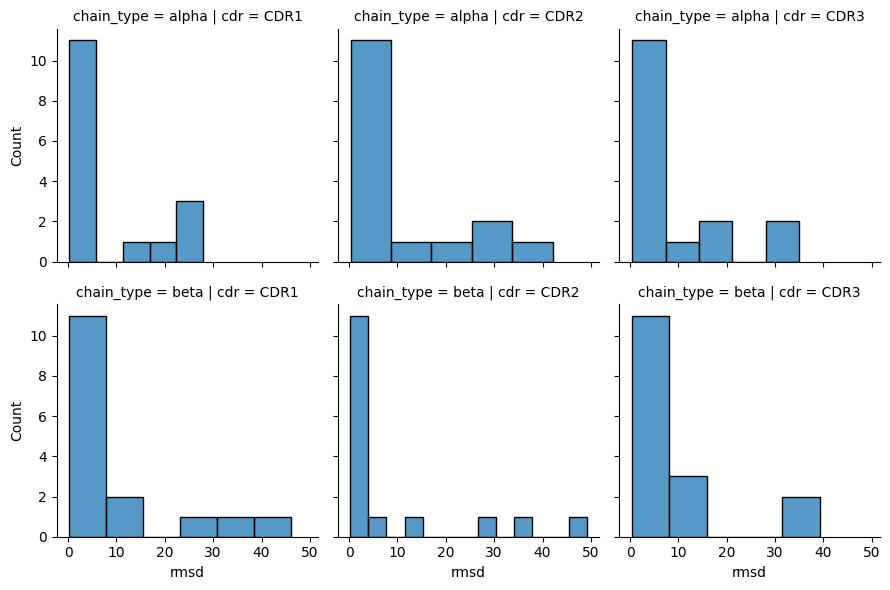

In [23]:
sns.histplot(results_avg, x='rmsd')

g = sns.FacetGrid(results_avg, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

In [24]:
factors = list(itertools.product(('alpha', 'beta'), ('CDR1', 'CDR2', 'CDR3')))
samples = []
for chain, cdr in factors:
    samples.append(results_avg.query('chain_type == @chain and cdr == @cdr')['rmsd'].to_numpy())

print(scipy.stats.kruskal(*samples))    

print('\n\nPost hoc analysis')
combos = list(itertools.combinations(factors, 2))
significance_level = 0.05 / len(combos)

p_values = []
statistics = []

for (chain_x, cdr_x), (chain_y, cdr_y) in combos:
    sample_x = results_avg.query('chain_type == @chain_x and cdr == @cdr_x')
    sample_x = sample_x.sort_values('group')
    
    sample_y = results_avg.query('chain_type == @chain_y and cdr == @cdr_y')
    sample_y = sample_y.sort_values('group')
    
    statistic, p_value = scipy.stats.wilcoxon(sample_x['rmsd'].to_numpy(), sample_y['rmsd'].to_numpy())
    
    statistics.append(statistic)
    p_values.append(p_value)

results_avg_stats = pd.DataFrame({
    'sample 1': [f"{cdr}{chain}" for (chain, cdr), _ in combos],
    'sample 2': [f"{cdr}{chain}" for _, (chain, cdr) in combos],
    'statistics': statistics,
    'p_val': p_values,
})
results_avg_stats['significant'] = results_avg_stats['p_val'].map(lambda p_val: p_val < significance_level)

results_avg_stats

KruskalResult(statistic=0.759342783505133, pvalue=0.9795537886021063)


Post hoc analysis


,sample 1,sample 2,statistics,p_val,significant
0,CDR1alpha,CDR2alpha,19.0,0.009186,False
1,CDR1alpha,CDR3alpha,64.0,0.860260,False
2,CDR1alpha,CDR1beta,56.0,0.561890,False
3,CDR1alpha,CDR2beta,57.0,0.596588,False
4,CDR1alpha,CDR3beta,68.0,1.000000,False
5,CDR2alpha,CDR3alpha,30.0,0.050659,False
6,CDR2alpha,CDR1beta,24.0,0.021393,False
7,CDR2alpha,CDR2beta,22.0,0.015503,False
8,CDR2alpha,CDR3beta,28.0,0.038635,False
9,CDR3alpha,CDR1beta,52.0,0.433197,False


The statistical tests show that there is **not any** significant differences in these results.